In [122]:
# Execute if necessary
# %%capture
# %pip install openml

In [123]:
# ! python -m nltk.downloader all ya van 11 x

In [124]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sb
import pandas as pd
from typing import Dict, Tuple, Union, List
from tqdm import tqdm
import openml
import re
import unicodedata
import sklearn
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

# Práctica 5: Introducción a Modelos de Clasificación

__Instrucciones__: A continuación hay una lista de funciones que debe implementar o tareas que debe desarrollar. La descripción de cada una de ellas se encuentra en la definición de cada una de las funciones.

La entrega de la práctica será en la siguiente sesión a menos que la indicación sea otra. La revisión iniciará al iniciar la sesión y únicamente podrá ser evaluada durante la duración de la sesión.

## Asignación 1

Implemente una clase que permita ajustar un modelo KNN. La clase debe cumplir con los siguientes requisitos:

- Debe contar con un método para realizar el entrenamiento en caso de ser requerido.
- Debe contar con un método para realizar las predicciones.
- Cada método debe imprimir una barra de progreso que permita conocer el tiempo estimado en que terminará.
- La clase debe permitir el uso de la distancia Mikownski y similitud coseno.

In [125]:
# A class that implement a knn classifier
class KNNClassifier:
    def __init__(self, k: int = 1, distance: str = "cos"):
        self.k = k
        self.distance = distance
        self.X = None
        self.y = None

    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        self.X = X
        self.y = y

    def predict(self, X: np.ndarray, p: int = 2) -> np.ndarray:
        """"
        Predict the class of each test point given a distance function

        Parameters:
        X: np.ndarray
            Test points
        distance: str
            Distance function to use. It can be 
            "cos" for cosine similarity
            "mink" for minkowski distance

        Returns: np.ndarray
            Predicted classes
        """
        dist = []
        # Calculate the distance between each test point and all training points
        if self.distance == "cos":
            for i in tqdm(range(X.shape[0]), desc ="Calculating distances"):
                dist.append(self.cosine_distance(X[i], self.X))
        elif self.distance == "mink":
            for i in tqdm(range(X.shape[0]), desc ="Calculating distances"):
                dist.append(self.minkowski_distance(X[i], self.X, p))

        # Find the k nearest points
        nearest = np.argsort(dist, axis=1)[:, :self.k]
        
        # Find the most common class among the k nearest points
        common_classes = []
        for i in tqdm(range(len(nearest)), desc ="Finding most common class"):
            common_classes.append(np.argmax(np.bincount(self.y[nearest[i]])))
        return common_classes
    
    # Mikownski distance function given a point and a set of points
    def minkowski_distance(self, x: np.ndarray, y: np.ndarray, p: int) -> float:
        distances = []
        for i in range(len(y)):
            distances.append(np.power(np.sum(np.power(np.abs(x - y[i]), p)), 1/p))
        return distances
    
    # cosine similarity function given a point and a set of points
    def cosine_distance(self, x: np.ndarray, y: np.ndarray) -> float:
        distances = []
        for i in range(len(y)):
            distances.append(np.dot(x, y[i]) / (np.linalg.norm(x) * np.linalg.norm(y[i])))
        return distances

## Asignación 2

Implemente una clase que permita ajustar un modelo Naive Bayes. La clase debe cumplir con los siguientes requisitos:

- Debe contar con un método para realizar el entrenamiento en caso de ser requerido.
- Debe contar con un método para realizar las predicciones.
- Cada método debe imprimir una barra de progreso que permita conocer el tiempo estimado en que terminará.

In [126]:
# A class that implement a naive bayes classifier
class NaiveBayesClassifier:
    def __init__(self):
        self.X = None
        self.y = None
        self.prior = []
        self.likelihood = []

    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        """
        Fit the model to the data X and y.

        Parameters:
        X: np.ndarray
            The data to fit the model to.
        y: np.ndarray
            The labels of the data.
        """       
        self.X = X
        self.y = y

        # Calculate the prior probability of each class
        self.prior = np.bincount(y) / len(y)

        # Calculate the likelihood of each feature given each class
        self.likelihood = np.zeros((len(np.unique(y)), X.shape[1]))
        for i in tqdm(range(len(np.unique(y))), desc ="Calculating likelihood"):
            for j in range(X.shape[1]):
                self.likelihood[i, j] = (np.sum(X[y == i, j]) + 1) / (np.sum(y == i) + 1)
        
    def predict(self, X: np.ndarray) -> np.ndarray:
        """
        Predict the class of each datain X.

        Parameters:
        X: np.ndarray
            The data to predict the class of.

        Returns: ndarray
            The predicted class of each data in X.
        """

        posterior = np.zeros((len(X), len(np.unique(self.y))))
        predictions = []

        # Calculate the posterior probability of each class given the data
        for i in tqdm(range(len(X)), desc ="Calculating posterior"):
            for j in range(len(np.unique(self.y))):
                posterior[i][j] = self.prior[j] * np.prod(((X[i]) * self.likelihood[j])+1)

        # Return the class with the highest posterior probability
        return np.argmax(posterior, axis = 1)


En esta sección se incluye un dataset real. El dataset importado se llama _spambase_ y puede leer su descripción en la siguiente liga

https://www.openml.org/d/42904

In [127]:
# Descarga la metadata del dataset
dataset_info = openml.datasets.get_dataset(42904, download_data=False)

target = "CLASS"

(
    features, # Dataframe con las características que se pueden utilizar para predecir
    outputs, # Columna a predecir
    _, # Máscara que indica que columnas de todas las características son categoricas
    columns # Lista con el nombre de las características
)= dataset_info.get_data(
    dataset_format="dataframe", target=target
)

columns = np.array(columns)

In [128]:
print(f"La columna a predecir se llama '{target}'")
print(f"Todas las características son {str(columns)}")

La columna a predecir se llama 'CLASS'
Todas las características son ['COMMENT_ID' 'AUTHOR' 'DATE' 'CONTENT']


In [129]:
# Impresión de las características
features

,COMMENT_ID,AUTHOR,DATE,CONTENT
0,LZQPQhLyRh80UYxNuaDWhIGQYNQ96IuCg-AYWqNPjpU,Julius NM,2013-11-07T06:20:48,"Huh, anyway check out this you[tube] channel: ..."
1,LZQPQhLyRh_C2cTtd9MvFRJedxydaVW-2sNg5Diuo4A,adam riyati,2013-11-07T12:37:15,Hey guys check out my new channel and our firs...
2,LZQPQhLyRh9MSZYnf8djyk0gEF9BHDPYrrK-qCczIY8,Evgeny Murashkin,2013-11-08T17:34:21,just for test I have to say murdev.com
3,z13jhp0bxqncu512g22wvzkasxmvvzjaz04,ElNino Melendez,2013-11-09T08:28:43,me shaking my sexy ass on my channel enjoy ^_^ ﻿
4,z13fwbwp1oujthgqj04chlngpvzmtt3r3dw,GsMega,2013-11-10T16:05:38,watch?v=vtaRGgvGtWQ Check this out .﻿
...,...,...,...,...
345,z13th1q4yzihf1bll23qxzpjeujterydj,Carmen Racasanu,2014-11-14T13:27:52,How can this have 2 billion views when there's...
346,z13fcn1wfpb5e51xe04chdxakpzgchyaxzo0k,diego mogrovejo,2014-11-14T13:28:08,I don't now why I'm watching this in 2014﻿
347,z130zd5b3titudkoe04ccbeohojxuzppvbg,BlueYetiPlayz -Call Of Duty and More,2015-05-23T13:04:32,subscribe to me for call of duty vids and give...
348,z12he50arvrkivl5u04cctawgxzkjfsjcc4,Photo Editor,2015-06-05T14:14:48,hi guys please my android photo editor downloa...


In [130]:
outputs

0      1
1      1
2      1
3      1
4      1
      ..
345    0
346    0
347    1
348    1
349    0
Name: CLASS, Length: 350, dtype: uint8

## Asignación 3

Realice el preprocesamiento que considere adecuado para que el dataset pueda ser procesado por un modelo de clasificación. __No olvide utilizar particionar en entrenamiento y validación, y realizar el preprocesamiento de manera adecuada__.

In [131]:
# Funciones de preprocesamiento

def sust_url(texto):
    texto = re.sub(r"(?P<url>https?://[^\s]+)", "url", texto)
    texto = re.sub(r"(watch\S+)", "url", texto)
    texto = re.sub(r"(www\S+)", "url", texto)
    texto = re.sub(r"(\w+\.(com))", "url", texto)
    texto = re.sub(r"(\w)\1+", r"\1", texto)
    return texto

def limpiar(texto):
    texto = texto.lower()
    texto = unicodedata.normalize('NFKD', texto).encode('ASCII', 'ignore').decode('utf-8')
    texto = re.sub(r'[^\w\s]', '', texto)
    texto = re.sub(r'\d+', '', texto)
    texto = re.sub(r'\s+', ' ', texto).strip()
    return texto

def sw(texto):
    words = word_tokenize(texto)
    words1 = [word for word in words if word not in stopwords.words('english')]
    words1 = [p for p in words1 if len(p) > 1] 
    texto = ' '.join(words1)
    return texto

In [132]:
datos = pd.DataFrame(features.CONTENT)
datos2 = pd.DataFrame(sust_url(datos['CONTENT'][k]) for k in range(len(datos)))
mail_clean = [limpiar(datos2[0][k]) for k in range(len(datos2))]
mail_clean2 = [sw(mail_clean[k]) for k in range(len(mail_clean))]
df = pd.DataFrame()
df['texto'] = mail_clean2
df

,texto
0,huh anyway check youtube chanel kobyoshi
1,hey guys check new chanel first vid us monkeys...
2,test say url
3,shaking sexy chanel enjoy
4,url check
...,...
345,bilion views theres planet lol
346,dont im url
347,subscribe cal duty vids give aways goal subs
348,hi guys please android photo editor download t...


In [133]:
ind = df.query('texto == ""').index
df = df.drop(ind, axis = 0)
df.query('texto == ""').index

Int64Index([], dtype='int64')

In [134]:
c = CountVectorizer()
bolsa = c.fit_transform(mail_clean2)
M = bolsa.toarray() 
df = pd.DataFrame(M, columns=c.vocabulary_.keys())

In [135]:
len(df)

350

In [136]:
X_train, X_val, y_train, y_val = sklearn.model_selection.train_test_split(
    M, 
    outputs, 
    test_size=0.7, 
    random_state=11
)

## Asignación 4

Realice una visualización de los datos en dos dimensiones. Posteriormente entrene un modelo de KNN (utilizando la clase implementada anteriormente) y valide que su modelo generaliza bien.

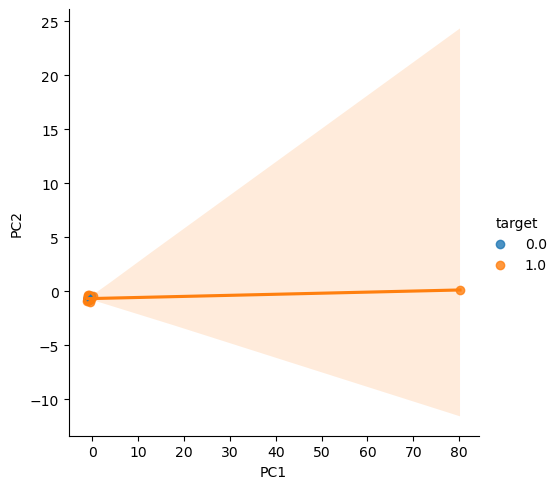

In [137]:
# Visualización de 2 dimensiones usando PCA
pca = PCA(n_components=2)

# Escalamos los datos
X_scaled = StandardScaler().fit_transform(X_train)

pca_features = pca.fit_transform(X_scaled)
 
pca_df = pd.DataFrame(
    data=pca_features, 
    columns=['PC1', 'PC2'])
pca_df['target'] = y_train

# Gaficamos los datos dependiendo del target
sns.lmplot(x='PC1',  y='PC2',  data=pca_df,  hue='target', legend=True)
plt.show()

In [138]:
def cross_val_score(model, X, y, cv=5):
    """
    Cross validation score for a given model.
    """
    kf = KFold(n_splits=cv, shuffle=True)
    scores = []
    for train_idx, val_idx in kf.split(X):
        X_train_n, y_train_n = X[train_idx], y[train_idx]
        X_val_n, y_val_n = X[val_idx], y[val_idx]
        model.fit(X_train_n, y_train_n)
        y_pred = model.predict(X_val_n)
        score = accuracy_score(y_val_n, y_pred)
        scores.append(score)
    return scores

In [139]:
# Scores de KNN con cross validation
# Choosing the best k
scores = np.zeros((2, 11))
for i, dis in enumerate(["cos", "mink"]):
    print(f"--- Calculating scores for distance={dis} ---")
    for k in range(1, 12):
        print(f"--- Calculating score for k={k} ---")
        scores[i, k-1] = np.mean(cross_val_score(KNNClassifier(k, dis), X_val, y_val.to_numpy(), cv=5))

--- Calculating scores for distance=cos ---
--- Calculating score for k=1 ---


Calculating distances:   0%|          | 0/49 [00:00<?, ?it/s]C:\Users\Iván\AppData\Local\Temp\ipykernel_19552\740839324.py:57: RuntimeWarning: invalid value encountered in true_divide
  distances.append(np.dot(x, y[i]) / (np.linalg.norm(x) * np.linalg.norm(y[i])))
Calculating distances:   0%|          | 0/49 [00:00<?, ?it/s]C:\Users\Iván\AppData\Local\Temp\ipykernel_19552\740839324.py:57: RuntimeWarning: invalid value encountered in true_divide
  distances.append(np.dot(x, y[i]) / (np.linalg.norm(x) * np.linalg.norm(y[i])))
Calculating distances:   0%|          | 0/49 [00:00<?, ?it/s]C:\Users\Iván\AppData\Local\Temp\ipykernel_19552\740839324.py:57: RuntimeWarning: invalid value encountered in true_divide
  distances.append(np.dot(x, y[i]) / (np.linalg.norm(x) * np.linalg.norm(y[i])))
Calculating distances:   0%|          | 0/49 [00:00<?, ?it/s]C:\Users\Iván\AppData\Local\Temp\ipykernel_19552\740839324.py:57: RuntimeWarning: invalid value encountered in true_divide
  distances.append(np

--- Calculating score for k=2 ---


Calculating distances:   0%|          | 0/49 [00:00<?, ?it/s]C:\Users\Iván\AppData\Local\Temp\ipykernel_19552\740839324.py:57: RuntimeWarning: invalid value encountered in true_divide
  distances.append(np.dot(x, y[i]) / (np.linalg.norm(x) * np.linalg.norm(y[i])))
Calculating distances:   0%|          | 0/49 [00:00<?, ?it/s]C:\Users\Iván\AppData\Local\Temp\ipykernel_19552\740839324.py:57: RuntimeWarning: invalid value encountered in true_divide
  distances.append(np.dot(x, y[i]) / (np.linalg.norm(x) * np.linalg.norm(y[i])))
Calculating distances:   0%|          | 0/49 [00:00<?, ?it/s]C:\Users\Iván\AppData\Local\Temp\ipykernel_19552\740839324.py:57: RuntimeWarning: invalid value encountered in true_divide
  distances.append(np.dot(x, y[i]) / (np.linalg.norm(x) * np.linalg.norm(y[i])))
Calculating distances:   0%|          | 0/49 [00:00<?, ?it/s]C:\Users\Iván\AppData\Local\Temp\ipykernel_19552\740839324.py:57: RuntimeWarning: invalid value encountered in true_divide
  distances.append(np

--- Calculating score for k=3 ---


Calculating distances:   0%|          | 0/49 [00:00<?, ?it/s]C:\Users\Iván\AppData\Local\Temp\ipykernel_19552\740839324.py:57: RuntimeWarning: invalid value encountered in true_divide
  distances.append(np.dot(x, y[i]) / (np.linalg.norm(x) * np.linalg.norm(y[i])))
Calculating distances:   0%|          | 0/49 [00:00<?, ?it/s]C:\Users\Iván\AppData\Local\Temp\ipykernel_19552\740839324.py:57: RuntimeWarning: invalid value encountered in true_divide
  distances.append(np.dot(x, y[i]) / (np.linalg.norm(x) * np.linalg.norm(y[i])))
Calculating distances:   0%|          | 0/49 [00:00<?, ?it/s]C:\Users\Iván\AppData\Local\Temp\ipykernel_19552\740839324.py:57: RuntimeWarning: invalid value encountered in true_divide
  distances.append(np.dot(x, y[i]) / (np.linalg.norm(x) * np.linalg.norm(y[i])))
Calculating distances:   0%|          | 0/49 [00:00<?, ?it/s]C:\Users\Iván\AppData\Local\Temp\ipykernel_19552\740839324.py:57: RuntimeWarning: invalid value encountered in true_divide
  distances.append(np

--- Calculating score for k=4 ---


Calculating distances:   0%|          | 0/49 [00:00<?, ?it/s]C:\Users\Iván\AppData\Local\Temp\ipykernel_19552\740839324.py:57: RuntimeWarning: invalid value encountered in true_divide
  distances.append(np.dot(x, y[i]) / (np.linalg.norm(x) * np.linalg.norm(y[i])))
Calculating distances:   0%|          | 0/49 [00:00<?, ?it/s]C:\Users\Iván\AppData\Local\Temp\ipykernel_19552\740839324.py:57: RuntimeWarning: invalid value encountered in true_divide
  distances.append(np.dot(x, y[i]) / (np.linalg.norm(x) * np.linalg.norm(y[i])))
Calculating distances:   0%|          | 0/49 [00:00<?, ?it/s]C:\Users\Iván\AppData\Local\Temp\ipykernel_19552\740839324.py:57: RuntimeWarning: invalid value encountered in true_divide
  distances.append(np.dot(x, y[i]) / (np.linalg.norm(x) * np.linalg.norm(y[i])))
Calculating distances:   0%|          | 0/49 [00:00<?, ?it/s]C:\Users\Iván\AppData\Local\Temp\ipykernel_19552\740839324.py:57: RuntimeWarning: invalid value encountered in true_divide
  distances.append(np

--- Calculating score for k=5 ---


Calculating distances:   0%|          | 0/49 [00:00<?, ?it/s]C:\Users\Iván\AppData\Local\Temp\ipykernel_19552\740839324.py:57: RuntimeWarning: invalid value encountered in true_divide
  distances.append(np.dot(x, y[i]) / (np.linalg.norm(x) * np.linalg.norm(y[i])))
Calculating distances:   0%|          | 0/49 [00:00<?, ?it/s]C:\Users\Iván\AppData\Local\Temp\ipykernel_19552\740839324.py:57: RuntimeWarning: invalid value encountered in true_divide
  distances.append(np.dot(x, y[i]) / (np.linalg.norm(x) * np.linalg.norm(y[i])))
Calculating distances:   0%|          | 0/49 [00:00<?, ?it/s]C:\Users\Iván\AppData\Local\Temp\ipykernel_19552\740839324.py:57: RuntimeWarning: invalid value encountered in true_divide
  distances.append(np.dot(x, y[i]) / (np.linalg.norm(x) * np.linalg.norm(y[i])))
Calculating distances:   0%|          | 0/49 [00:00<?, ?it/s]C:\Users\Iván\AppData\Local\Temp\ipykernel_19552\740839324.py:57: RuntimeWarning: invalid value encountered in true_divide
  distances.append(np

--- Calculating score for k=6 ---


Calculating distances:   0%|          | 0/49 [00:00<?, ?it/s]C:\Users\Iván\AppData\Local\Temp\ipykernel_19552\740839324.py:57: RuntimeWarning: invalid value encountered in true_divide
  distances.append(np.dot(x, y[i]) / (np.linalg.norm(x) * np.linalg.norm(y[i])))
Calculating distances:   0%|          | 0/49 [00:00<?, ?it/s]C:\Users\Iván\AppData\Local\Temp\ipykernel_19552\740839324.py:57: RuntimeWarning: invalid value encountered in true_divide
  distances.append(np.dot(x, y[i]) / (np.linalg.norm(x) * np.linalg.norm(y[i])))
Calculating distances:   0%|          | 0/49 [00:00<?, ?it/s]C:\Users\Iván\AppData\Local\Temp\ipykernel_19552\740839324.py:57: RuntimeWarning: invalid value encountered in true_divide
  distances.append(np.dot(x, y[i]) / (np.linalg.norm(x) * np.linalg.norm(y[i])))
Calculating distances:   0%|          | 0/49 [00:00<?, ?it/s]C:\Users\Iván\AppData\Local\Temp\ipykernel_19552\740839324.py:57: RuntimeWarning: invalid value encountered in true_divide
  distances.append(np

--- Calculating score for k=7 ---


Calculating distances:   0%|          | 0/49 [00:00<?, ?it/s]C:\Users\Iván\AppData\Local\Temp\ipykernel_19552\740839324.py:57: RuntimeWarning: invalid value encountered in true_divide
  distances.append(np.dot(x, y[i]) / (np.linalg.norm(x) * np.linalg.norm(y[i])))
Calculating distances:   0%|          | 0/49 [00:00<?, ?it/s]C:\Users\Iván\AppData\Local\Temp\ipykernel_19552\740839324.py:57: RuntimeWarning: invalid value encountered in true_divide
  distances.append(np.dot(x, y[i]) / (np.linalg.norm(x) * np.linalg.norm(y[i])))
Calculating distances:   0%|          | 0/49 [00:00<?, ?it/s]C:\Users\Iván\AppData\Local\Temp\ipykernel_19552\740839324.py:57: RuntimeWarning: invalid value encountered in true_divide
  distances.append(np.dot(x, y[i]) / (np.linalg.norm(x) * np.linalg.norm(y[i])))
Calculating distances:   0%|          | 0/49 [00:00<?, ?it/s]C:\Users\Iván\AppData\Local\Temp\ipykernel_19552\740839324.py:57: RuntimeWarning: invalid value encountered in true_divide
  distances.append(np

--- Calculating score for k=8 ---


Calculating distances:   0%|          | 0/49 [00:00<?, ?it/s]C:\Users\Iván\AppData\Local\Temp\ipykernel_19552\740839324.py:57: RuntimeWarning: invalid value encountered in true_divide
  distances.append(np.dot(x, y[i]) / (np.linalg.norm(x) * np.linalg.norm(y[i])))
Calculating distances:   0%|          | 0/49 [00:00<?, ?it/s]C:\Users\Iván\AppData\Local\Temp\ipykernel_19552\740839324.py:57: RuntimeWarning: invalid value encountered in true_divide
  distances.append(np.dot(x, y[i]) / (np.linalg.norm(x) * np.linalg.norm(y[i])))
Calculating distances:   0%|          | 0/49 [00:00<?, ?it/s]C:\Users\Iván\AppData\Local\Temp\ipykernel_19552\740839324.py:57: RuntimeWarning: invalid value encountered in true_divide
  distances.append(np.dot(x, y[i]) / (np.linalg.norm(x) * np.linalg.norm(y[i])))
Calculating distances:   0%|          | 0/49 [00:00<?, ?it/s]C:\Users\Iván\AppData\Local\Temp\ipykernel_19552\740839324.py:57: RuntimeWarning: invalid value encountered in true_divide
  distances.append(np

--- Calculating score for k=9 ---


Calculating distances:   0%|          | 0/49 [00:00<?, ?it/s]C:\Users\Iván\AppData\Local\Temp\ipykernel_19552\740839324.py:57: RuntimeWarning: invalid value encountered in true_divide
  distances.append(np.dot(x, y[i]) / (np.linalg.norm(x) * np.linalg.norm(y[i])))
Calculating distances:   0%|          | 0/49 [00:00<?, ?it/s]C:\Users\Iván\AppData\Local\Temp\ipykernel_19552\740839324.py:57: RuntimeWarning: invalid value encountered in true_divide
  distances.append(np.dot(x, y[i]) / (np.linalg.norm(x) * np.linalg.norm(y[i])))
Calculating distances:   0%|          | 0/49 [00:00<?, ?it/s]C:\Users\Iván\AppData\Local\Temp\ipykernel_19552\740839324.py:57: RuntimeWarning: invalid value encountered in true_divide
  distances.append(np.dot(x, y[i]) / (np.linalg.norm(x) * np.linalg.norm(y[i])))
Calculating distances:   0%|          | 0/49 [00:00<?, ?it/s]C:\Users\Iván\AppData\Local\Temp\ipykernel_19552\740839324.py:57: RuntimeWarning: invalid value encountered in true_divide
  distances.append(np

--- Calculating score for k=10 ---


Calculating distances:   0%|          | 0/49 [00:00<?, ?it/s]C:\Users\Iván\AppData\Local\Temp\ipykernel_19552\740839324.py:57: RuntimeWarning: invalid value encountered in true_divide
  distances.append(np.dot(x, y[i]) / (np.linalg.norm(x) * np.linalg.norm(y[i])))
Calculating distances:   0%|          | 0/49 [00:00<?, ?it/s]C:\Users\Iván\AppData\Local\Temp\ipykernel_19552\740839324.py:57: RuntimeWarning: invalid value encountered in true_divide
  distances.append(np.dot(x, y[i]) / (np.linalg.norm(x) * np.linalg.norm(y[i])))
Calculating distances:   0%|          | 0/49 [00:00<?, ?it/s]C:\Users\Iván\AppData\Local\Temp\ipykernel_19552\740839324.py:57: RuntimeWarning: invalid value encountered in true_divide
  distances.append(np.dot(x, y[i]) / (np.linalg.norm(x) * np.linalg.norm(y[i])))
Calculating distances:   0%|          | 0/49 [00:00<?, ?it/s]C:\Users\Iván\AppData\Local\Temp\ipykernel_19552\740839324.py:57: RuntimeWarning: invalid value encountered in true_divide
  distances.append(np

--- Calculating score for k=11 ---


Calculating distances:   0%|          | 0/49 [00:00<?, ?it/s]C:\Users\Iván\AppData\Local\Temp\ipykernel_19552\740839324.py:57: RuntimeWarning: invalid value encountered in true_divide
  distances.append(np.dot(x, y[i]) / (np.linalg.norm(x) * np.linalg.norm(y[i])))
Calculating distances:   0%|          | 0/49 [00:00<?, ?it/s]C:\Users\Iván\AppData\Local\Temp\ipykernel_19552\740839324.py:57: RuntimeWarning: invalid value encountered in true_divide
  distances.append(np.dot(x, y[i]) / (np.linalg.norm(x) * np.linalg.norm(y[i])))
Calculating distances:   0%|          | 0/49 [00:00<?, ?it/s]C:\Users\Iván\AppData\Local\Temp\ipykernel_19552\740839324.py:57: RuntimeWarning: invalid value encountered in true_divide
  distances.append(np.dot(x, y[i]) / (np.linalg.norm(x) * np.linalg.norm(y[i])))
Calculating distances:   0%|          | 0/49 [00:00<?, ?it/s]C:\Users\Iván\AppData\Local\Temp\ipykernel_19552\740839324.py:57: RuntimeWarning: invalid value encountered in true_divide
  distances.append(np

--- Calculating scores for distance=mink ---
--- Calculating score for k=1 ---


Finding most common class: 100%|██████████| 49/49 [00:00<?, ?it/s]


--- Calculating score for k=2 ---


Finding most common class: 100%|██████████| 49/49 [00:00<?, ?it/s]


--- Calculating score for k=3 ---


Finding most common class: 100%|██████████| 49/49 [00:00<?, ?it/s]


--- Calculating score for k=4 ---


Finding most common class: 100%|██████████| 49/49 [00:00<?, ?it/s]


--- Calculating score for k=5 ---


Finding most common class: 100%|██████████| 49/49 [00:00<?, ?it/s]


--- Calculating score for k=6 ---


Finding most common class: 100%|██████████| 49/49 [00:00<00:00, 48817.31it/s]


--- Calculating score for k=7 ---


Finding most common class: 100%|██████████| 49/49 [00:00<00:00, 48921.90it/s]


--- Calculating score for k=8 ---


Finding most common class: 100%|██████████| 49/49 [00:00<?, ?it/s]


--- Calculating score for k=9 ---


Finding most common class: 100%|██████████| 49/49 [00:00<?, ?it/s]


--- Calculating score for k=10 ---


Finding most common class: 100%|██████████| 49/49 [00:00<?, ?it/s]


--- Calculating score for k=11 ---


Finding most common class: 100%|██████████| 49/49 [00:00<00:00, 49050.33it/s]


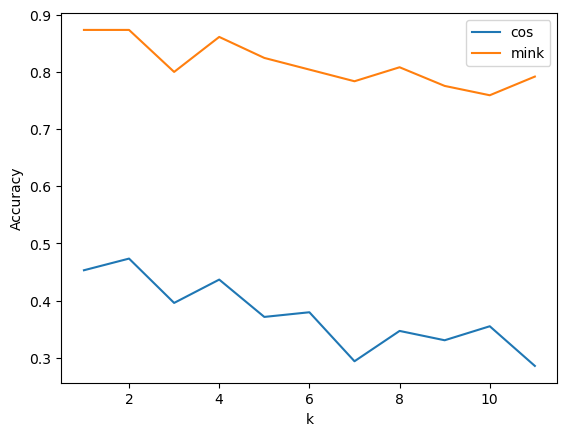

In [140]:
# Plotting the scores
plt.plot(range(1, 12), scores[0], label="cos")
plt.plot(range(1, 12), scores[1], label="mink")
plt.legend()
plt.xlabel("k")
plt.ylabel("Accuracy")
plt.show()

In [141]:
knn = KNNClassifier(k=4, distance="mink")

# Fit the model
knn.fit(X_train, y_train.to_numpy())

# Predict
y_pred = knn.predict(X_train)

Finding most common class: 100%|██████████| 105/105 [00:00<00:00, 104832.64it/s]


In [142]:
# Calculate the accuracy
print(f"Accuracy: {np.sum(y_pred == y_train) / len(y_train)}")

Accuracy: 0.819047619047619


## Asignación 5

Entrene un modelo de Naive Bayes (utilizando la clase implementada anteriormente) y valide que su modelo generaliza bien.

In [143]:
scores = cross_val_score(NaiveBayesClassifier(), X_val, y_val.to_numpy(), cv=5)
print(f"Accuracy: {np.mean(scores)}")

Calculating posterior: 100%|██████████| 49/49 [00:00<00:00, 24487.18it/s]

Accuracy: 0.9020408163265307


In [144]:
# Create the naive bayes classifier
nb = NaiveBayesClassifier()
nb.fit(X_train, y_train)

y_pred = nb.predict(X_train)

Calculating posterior: 100%|██████████| 105/105 [00:00<00:00, 34974.74it/s]


In [145]:
print(f"Accuracy: {np.sum(y_pred == y_train) / len(y_train)}")

Accuracy: 0.8
